# Spotify wrapped myself! - SQL project

Spotify keep a record of every time we listen to a song. They use this to produce the yearly Spotify Wrapped where they tell us our most listened artists of the year etc. Here is mine for 2019:

*(Side note: You're about to get a glimpse into music taste... don't judge me!)*

![my spotify wrapped 2019](official_spotify_wrapped.jfif)

It is possible to request your stored data from Spotify. I did this and attempt to recreate my Spotify Wrapped the long way - flexing some newly aquired SQL skills.

## Data download to SQL database

The data comes in JSON format with entries that look a bit like this:
   
*endTime:"2018-12-10 20:03"  
artistName:"Whitney Houston"   
trackName:"How Will I Know"   
msPlayed:93706*
   
I used this website (https://numidian.io/convert/json/to/sqlite) to convert the JSON file to a SQLite database. To control SQLite through Python I used the sqlite3 package and found this tutorial (https://stackabuse.com/a-sqlite-tutorial-with-python/) very helpful. Finally I created a second table in my database (see create_artist_table.ipynb) by scraping data from the Spotify Web API (using the spotipy package). This second table contains the columns (artist, genre, popularity). (Note. I learnt to use the Spotify Web API in my Album Covers project: https://github.com/Jacob-Lang/APIs---Spotify-Album-Covers/blob/master/AlbumCoverColoursByGenre.ipynb .)

## Set up

Just some dependencies and set up here:

In [18]:
%matplotlib inline

# To input json->sqlite conversion (sqlify-export.sql) into the database run in terminal (after creating db.sqlite3)
# sqlite3 db.sqlite3 < sqlify-export.sql

import sqlite3  # to run SQLite through Python
import utils # contains a custom function to present the tables nicely.

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# connect to database and create cursor object
con = sqlite3.connect('db.sqlite3')
cur = con.cursor()

## View history table

The streaming data is stored in the history table. The data about the artists is contained in the artist table. We can view the first few entries of each as follows:

In [3]:
# See data in history table 
sql_command = """SELECT * FROM history"""    # write SQLite  commands like this
cur.execute(sql_command)                     # execute them like this
print('The first 10 entries in the history table are:')
utils.show_table(cur, 10)                    # custom function in utils for displaying the resultant tables a bit nicer

The first 10 entries in the history table are:


endTime,artistName,trackName,msPlayed
2018-12-10 20:03,Whitney Houston,How Will I Know,93706
2018-12-13 10:21,Stereophonics,Indian Summer,133240
2018-12-13 17:01,King Krule,Easy Easy,20505
2018-12-14 11:08,King Krule,Easy Easy,880
2018-12-14 11:12,Ariana Grande,imagine,212293
2018-12-14 11:16,Todd Terry,Just Getting Warm,216774
2018-12-14 11:19,ZAYN,There You Are,199600
2018-12-14 15:39,ON / OFF / ON,Lifelines,5852
2018-12-14 15:39,Night Flight,Song to Fall Asleep,192500
2018-12-14 15:42,Jammz,Play That,209000


In [4]:
# See data in artist table (made myself in create_artist_table.ipynb)  
sql_command = """SELECT * FROM artist"""
cur.execute(sql_command)
print('The first 10 entries in the artist table are:')
utils.show_table(cur, 10)

The first 10 entries in the artist table are:


artistName,genre,popularity
Whitney Houston,dance pop,84
Stereophonics,britpop,70
King Krule,indietronica,64
Ariana Grande,dance pop,97
Todd Terry,chicago house,56
ZAYN,dance pop,87
ON / OFF / ON,NULL,9
Night Flight,modern hard rock,43
Jammz,grime,34
Filthy Gears,instrumental grime,35


Note: The "popularity" column in the arist table is a popularity rating given to artists by Spotify based on recent and historic listening trends. Also, Spotify API returns a list of genres for each artsit ordered alphabetically. I simply chose to select the first genre from this list. This creates mildly unexpected results as discussed later and should be improved in future revisions.)

## Most played artist and track

Now my database tables are good to go I can use SQL commands to directly find out the most played artist (I'll measure this by total listening time) and most played tracks (I'll measure this by number of plays).

In [5]:
# Most played artists  CHANGE THIS TO MOST PLAYED IN MINUTES/HOURS.
#sql_command = """SELECT artistName, COUNT(m) AS cnt FROM history GROUP BY artistName ORDER BY cnt DESC"""
sql_command = """SELECT artistName, ROUND(SUM(msPlayed)/(60*60*1000.0),1) AS hours_listened FROM history GROUP BY artistName ORDER BY hours_listened DESC"""
cur.execute(sql_command)
print('My most listened artists by time played were:')
utils.show_table(cur, 10)

My most listened artists by time played were:


artistName,hours_listened
Bon Iver,17.3
Ariana Grande,14.9
Skepta,8.6
The 1975,8.3
SZA,7.6
DaVido,7.2
D'Angelo,5.5
Foals,4.9
Frank Ocean,4.8
Little Simz,4.7


This is an excellent match to the official Spotify Wrapped I was given! (refer to image at top.) The only discrepancy is the swapped order of The 1975 and Skepta but there is less than an hours listening difference so this can be explained by my year of downloaded data from Spotify not exactly corresponding with the year measured by Spotify in the official Spotify Wrapped.

In [6]:
# run SQL command on database. Most played tracks CHANGE TO BY MINS/HOURS AS WELL. OR KEEP.
sql_command = """SELECT trackName, COUNT(trackName) AS num_plays FROM history GROUP BY trackName ORDER BY num_plays DESC"""
cur.execute(sql_command)
print('My most listened tracks by number of plays were:')
utils.show_table(cur, 10)

My most listened tracks by number of plays were:


trackName,num_plays
No Sleep,42
"Hey\, Ma",38
Supermodel,38
Bullet From A Gun,34
Sunflower - Spider-Man: Into the Spider-Verse,34
What Do You Mean?,33
U (Man Like),32
Dangerous Woman,31
bad idea,30
Be Alright,28


This corresponds less well with the official Spotify wrapped however this difference of num_plays in the top ten is only 14 so it is clear to see how this order could change on a daily basis. The discrepancy is then explained by not knowing the exact period Spotify takes data from. 

## Total listen time and most played genre

To complete the comparison with the official Spotify Wrapped I can find the total minutes listened and my favourite genre:

In [7]:
# Sum total msPlayed
sql_command = """SELECT SUM(msPlayed)/(60*1000.0) FROM history"""
cur.execute(sql_command)
total_playtime = round(cur.fetchall()[0][0]) # in minutes
print('Total listen time:', total_playtime, 'minutes')

Total listen time: 17800 minutes


Again we see a small discrepancy, as discussed above, but this is a very close match. 

In [8]:
# Most played genre by time played
# To find this I need to JOIN the history and artist tables - this is a key functionality of SQL

sql_command = """
SELECT genre, COUNT(genre) AS cnt
FROM
(SELECT history.artistName AS artistName, artist.genre AS genre
FROM history
JOIN artist
ON history.artistName = artist.artistName)
GROUP BY genre
ORDER BY cnt DESC

"""
sql_command = """
SELECT genre, ROUND(SUM(msPlayed)/(60*60*1000.0),1) AS hours_played
FROM
(SELECT history.msPlayed AS msPlayed, artist.genre AS genre
FROM history
JOIN artist
ON history.artistName = artist.artistName)
GROUP BY genre
ORDER BY hours_played DESC

"""
cur.execute(sql_command)
utils.show_table(cur,10)

genre,hours_played
dance pop,31.1
chamber pop,23.3
alternative r&b,21.4
grime,14.0
album rock,13.6
alternative dance,10.8
birmingham grime,9.1
NULL,8.3
indie pop,8.3
afropop,8.2


Now this really doesn't match my official most listened genre: Rock. This is because in the process of populating my artist table from the Spotify Web API, I chose only one genre from a list of genres (per artist) provided by Spotify. I simply chose the first genre in the list (which is ordered alphabetically) --- and this explains the apperance of fairly niche genres like *Birmingham Grime* and *Chamber Pop*. A better method of genre selection would be to rank all genres by general popularity and then choose the most popular genre from each list.

## and more... 

Well since I have the data why stop there.  

### Listens by month

Here I plot the listening time by month

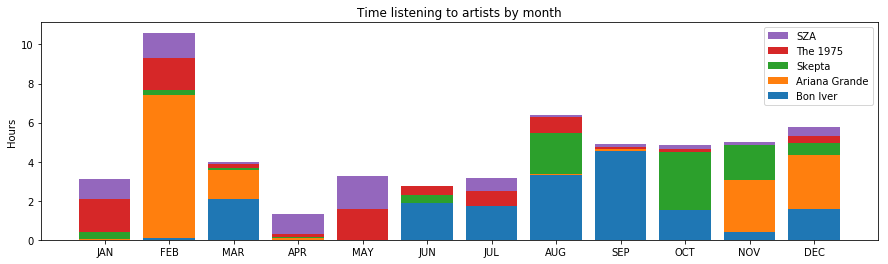

In [11]:
# Hours played per month

fig = plt.figure(figsize = (15,4)) 
ax = plt.subplot()
bottom = np.zeros(12)
for artist_name in ["Bon Iver", "Ariana Grande", "Skepta", "The 1975", "SZA"]:
    months, hours = utils.hours_played_by_month(cur, artist_name)
    plt.bar(months, hours, label = artist_name, bottom = bottom)
    bottom = bottom + hours # do this to make a stacked bar graph.
    
# Legend
plt.legend(loc = 'best')
# to have legend labels same order as stack
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))

# title
plt.title('Time listening to artists by month')

# axes
plt.ylabel('Hours')
plt.xticks(months, ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']);


Here we can see several trends:
1. I listened to A LOT of Ariana Grande in February. A quick check shows that she released her her album "Thank U, Next" on February 8th. 
2. I listen to Bon iver pretty steadily through summer and autumn. Their new album was released on August 8th explained a peak in September.
3. I listened to SZA pretty steadily throughout the year.
4. I listened to a lot more Skepta in the second half of the year than the first.   

### Race to most listened artist

How about the race to most listened: 

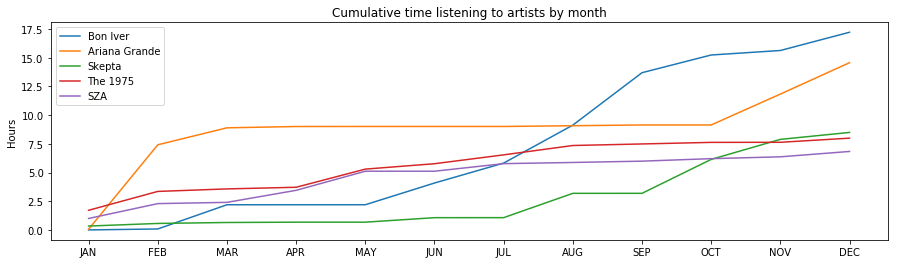

In [12]:
# Cumulative hours listened over the year

fig = plt.figure(figsize = (15,4)) 
ax = plt.subplot()
for artist_name in ["Bon Iver", "Ariana Grande", "Skepta", "The 1975", "SZA"]:
    months, hours = utils.hours_played_by_month(cur, artist_name)
    plt.plot(months, np.cumsum(hours), label = artist_name)
    
# Legend
plt.legend(loc = 'best')
# to have legend labels same order as stack
handles, labels = ax.get_legend_handles_labels()

# title
plt.title('Cumulative time listening to artists by month')

# axes
plt.ylabel('Hours')
plt.xticks(months, ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']);

Here we see Ariana Grande rapidly rose to most listened by February, Bon Iver took over around August and Skepta pipped The 1975 to 3rd place in the final two months of the year. A close race!

### Over- and under-rated artists

Finally I can compare Spotify's popularity measure with a measure of my own rating. My rating is the normalised number of listens by artist. So that my most listened artist (Bon Iver) has a rating of 1.

My comparing Spotify's popularity rating with my rating I can see which artists I think are over- or under-rated by Spotify. Or equivalently, over- and under-rated by the public in general. 

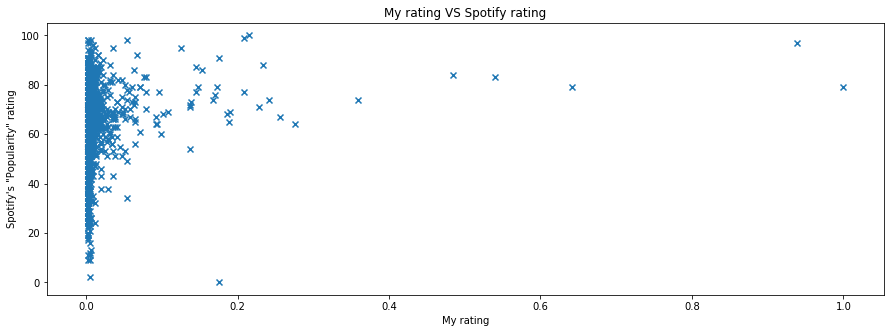

In [19]:
# JOIN tables to compare spotifys popularity measure with my listens
sql_command = """
SELECT DISTINCT hist_count.artistName, hist_count.cnt, artist.popularity
FROM (SELECT artistName, COUNT(artistName) AS cnt FROM history GROUP BY artistName) AS hist_count 
JOIN artist 
ON hist_count.artistName = artist.artistName
ORDER BY cnt DESC"""
cur.execute(sql_command)
results = cur.fetchall()

my_rating = [(entry[1]/results[0][1]) for entry in results]
spotify_pop = [entry[2] for entry in results]

plt.figure(figsize = (15,5))
plt.scatter(my_rating, spotify_pop, marker = 'x')

# title
plt.title('My rating VS Spotify rating')

# axes
plt.ylabel('Spotify\'s "Popularity" rating')
plt.xlabel('My rating');

In the case that Spotify and I agreed completely on the rating of each song we would expect the plot to show a single monotonously increasing (but probably not linear) function. With this assumption we can make a general statement that any artists who fall on the bottom-right edge of the distribution are artists that I think are better that Spotify does... i.e artists I think Spotify has under-rated. Artists in the top-left corner are artists I think Spotify has over-rated. 

For instance the entry around (0.18, 0) is D'Angelo which Spotify has given a popularity rating of 0. This plot shows that I think D'Angelo is massively under-rated!

## The end

In [18]:
# to close the sqlite3 console
con.close()

(This idea for this work was inspired by this article https://towardsdatascience.com/i-wrapped-my-spotify-history-the-hard-way-93dc832d9b47 however my implementation was original and our data analyses are different. )